# Logistic regression model

One, two, you know what to do...

**Note**: For Kaggle compatibility, use scikit-learn 1.2.2 when training this model. Kaggle's environment uses sklearn 1.2.2, and models saved with newer versions may not deserialize properly.

## Notebook set up

### Imports

In [1]:
# Standard library imports
import os
import sys
import time
import tracemalloc
from datetime import datetime
from pathlib import Path

# Set environment variable to limit thread usage by underlying linear algebra libraries.
# Note: this must be set before importing numpy, pandas, or sklearn.
os.environ['OMP_NUM_THREADS'] = '1'

# Third party imports
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import uniform, loguniform, randint
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, PolynomialFeatures

# Add models directory to path for custom transformers
models_path = Path('../models').resolve()
sys.path.insert(0, str(models_path))

# Import custom transformers from models directory
from logistic_regression_transformers import (
    IDColumnDropper,
    IQRClipper,
    ConstantFeatureRemover
)

# Import utility functions from notebooks/functions
from functions.logistic_regression import (
    random_search_test,
    build_runtime_model,
    build_memory_model,
    calculate_optimal_iterations,
    calculate_optimal_sample_size,
    plot_runtime_model,
    plot_memory_model
)

### Run configuration

In [2]:
# Lucky random state for reproducibility
RANDOM_STATE = 315

# Set to true to run individual preprocessing/feature engineering steps
CHECK_PIPELINE_STEPS = True

# Number of cross-validation folds
CV_FOLDS = 3

# Number of threads to use for model optimization
N_JOBS = 10

# Set to True to run random search resource test
RANDOM_SEARCH_TEST = False

# Target runtime limit for optimization
RUNTIME_LIMIT_MIN = 3 * 8 * 60

# Memory target
MEMORY_LIMIT_GB = 30

### Data loading

In [3]:
train_df_path = 'https://gperdrizet.github.io/FSA_devops/assets/data/unit3/diabetes_prediction_train.csv'

# Load the training dataset
train_df = pd.read_csv(train_df_path)

# Display first few rows of training data
train_df.head().transpose()

,0,1,2,3,4
id,0,1,2,3,4
age,31,50,32,54,54
alcohol_consumption_per_week,1,2,3,3,1
physical_activity_minutes_per_week,45,73,158,77,55
diet_score,7.7,5.7,8.5,4.6,5.7
sleep_hours_per_day,6.8,6.5,7.4,7.0,6.2
screen_time_hours_per_day,6.1,5.8,9.1,9.2,5.1
bmi,33.4,23.8,24.1,26.6,28.8
waist_to_hip_ratio,0.93,0.83,0.83,0.83,0.9
systolic_bp,112,120,95,121,108


In [4]:
# Display dataset information (columns, dtypes, non-null counts)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 26 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   id                                  700000 non-null  int64  
 1   age                                 700000 non-null  int64  
 2   alcohol_consumption_per_week        700000 non-null  int64  
 3   physical_activity_minutes_per_week  700000 non-null  int64  
 4   diet_score                          700000 non-null  float64
 5   sleep_hours_per_day                 700000 non-null  float64
 6   screen_time_hours_per_day           700000 non-null  float64
 7   bmi                                 700000 non-null  float64
 8   waist_to_hip_ratio                  700000 non-null  float64
 9   systolic_bp                         700000 non-null  int64  
 10  diastolic_bp                        700000 non-null  int64  
 11  heart_rate                

## 1. Data Preprocessing

### 1.1. Column definitions

In [5]:
# Define the label
label = 'diagnosed_diabetes'

# Define numerical features to apply IQR clipping
numerical_features = ['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history']

# Define ordinal features to encode
ordinal_features = ['education_level', 'income_level']

# Define ordinal categories in order
education_categories = [['No formal', 'Highschool', 'Graduate', 'Postgraduate']]
income_categories = [['Low', 'Lower-Middle', 'Middle', 'Upper-Middle', 'High']]

# Define features for one-hot encoding
nominal_features = ['gender', 'ethnicity', 'smoking_status', 'employment_status']

### 1.2. Remove ID column

In [6]:
# Apply ID column dropper
if CHECK_PIPELINE_STEPS:

    # Drop ID column using custom transformer
    id_dropper = IDColumnDropper(id_column='id')
    train_df = id_dropper.fit_transform(train_df)
    
    print(f'ID column removed')
    print(f'Remaining columns: {list(train_df.columns)}')

ID column removed
Remaining columns: ['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'gender', 'ethnicity', 'education_level', 'income_level', 'smoking_status', 'employment_status', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history', 'diagnosed_diabetes']


### 1.3. Numerical features

#### 1.3.1. Outlier clipping

In [7]:
# Apply IQR clipping to numerical features
if CHECK_PIPELINE_STEPS:

    # Clip outliers at 2.0*IQR (Note: threshold will be optimized later)
    clipper = IQRClipper(iqr_multiplier=2.0)
    numerical_data = train_df[numerical_features].values
    numerical_clipped = clipper.fit_transform(numerical_data)

#### 1.3.2. Standard scaling

In [8]:
# Apply standard scaling
if CHECK_PIPELINE_STEPS:

    scaler = StandardScaler()
    numerical_scaled = scaler.fit_transform(numerical_clipped)

    # Replace original features with clipped and scaled values
    train_df[numerical_features] = numerical_scaled

#### 1.3.3. Final numerical feature distributions

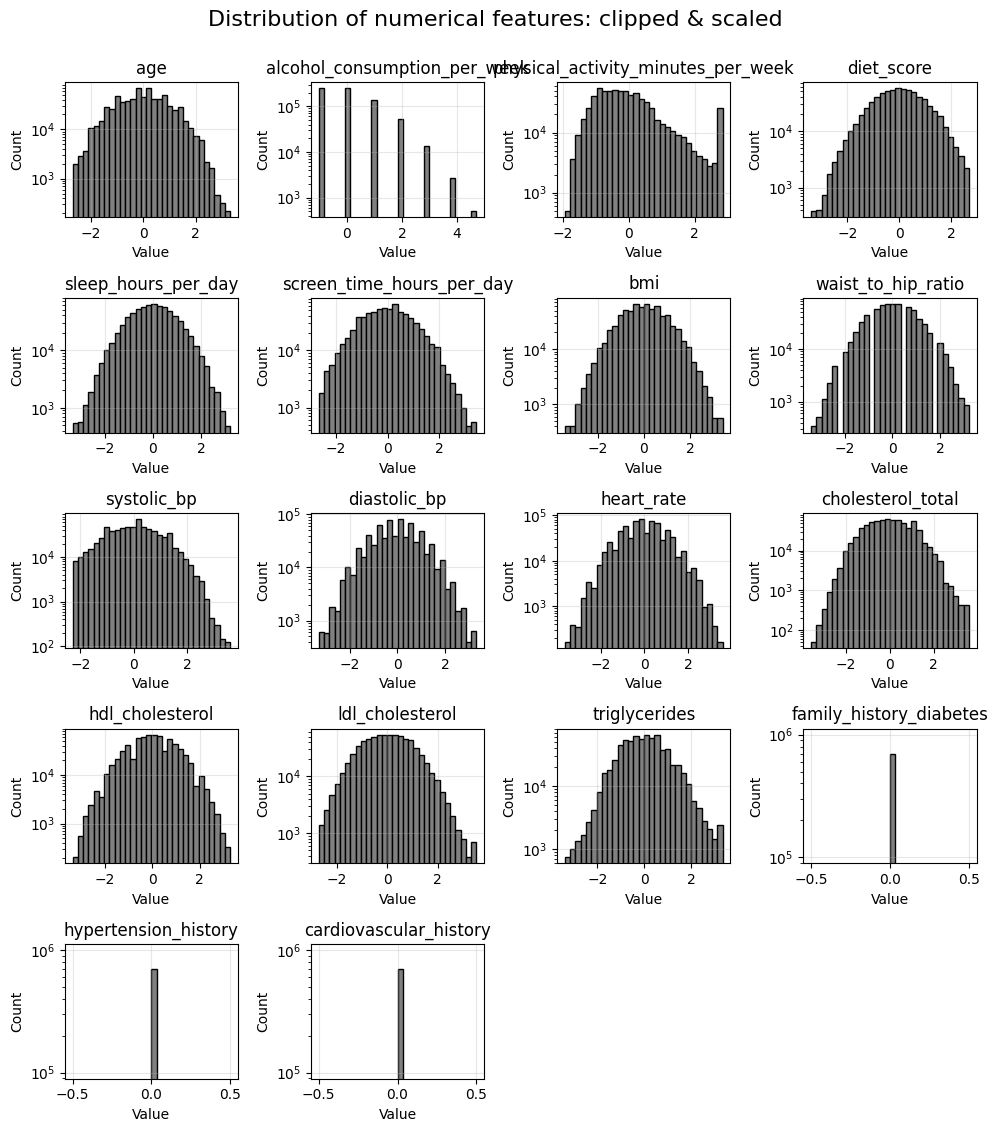

In [9]:
# Create distribution plots for scaled data
if CHECK_PIPELINE_STEPS:
    
    num_cols = 4
    num_rows = len(numerical_features) // num_cols + (len(numerical_features) % num_cols > 0)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*2.5, num_rows*2.3))
    axes = axes.flatten()
    fig.suptitle('Distribution of numerical features: clipped & scaled', fontsize=16)

    for i, feature in enumerate(numerical_features):
        
        # Plot scaled data from training dataframe
        axes[i].hist(train_df[feature], bins=30, edgecolor='black', color='grey')
        axes[i].set_title(f'{feature}')
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Count')
        axes[i].set_yscale('log')
        axes[i].grid(True, alpha=0.3)

    # Turn off unused axes
    for i in range(len(numerical_features), len(axes)):
        axes[i].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

### 1.4. Categorical features

#### 1.4.1. Ordinal feature encoding

In [10]:
if CHECK_PIPELINE_STEPS:

    # Create ordinal encoder with categories
    ordinal_encoder = OrdinalEncoder(
        categories=education_categories + income_categories,
        handle_unknown='use_encoded_value',
        unknown_value=-1
    )

    # Fit and transform ordinal features
    ordinal_encoded = ordinal_encoder.fit_transform(train_df[ordinal_features])
    train_df[ordinal_features] = ordinal_encoded

    # Remove original ordinal features and add encoded versions
    train_df.drop(columns=ordinal_features, inplace=True)

#### 1.4.2. Nominal feature encoding

In [11]:
if CHECK_PIPELINE_STEPS:

    # Create one-hot encoder
    onehot_encoder = OneHotEncoder(
        drop='first',
        sparse_output=False,
        handle_unknown='ignore'
    )

    # Convert encoded features to DataFrame
    encoded_features_df = pd.DataFrame(
        onehot_encoder.fit_transform(train_df[nominal_features]),
        columns=onehot_encoder.get_feature_names_out(nominal_features)
    )

    # Remove original nominal features and add encoded versions
    train_df = pd.concat([train_df.drop(columns=nominal_features), encoded_features_df], axis=1)
    train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 30 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   age                                 700000 non-null  float64
 1   alcohol_consumption_per_week        700000 non-null  float64
 2   physical_activity_minutes_per_week  700000 non-null  float64
 3   diet_score                          700000 non-null  float64
 4   sleep_hours_per_day                 700000 non-null  float64
 5   screen_time_hours_per_day           700000 non-null  float64
 6   bmi                                 700000 non-null  float64
 7   waist_to_hip_ratio                  700000 non-null  float64
 8   systolic_bp                         700000 non-null  float64
 9   diastolic_bp                        700000 non-null  float64
 10  heart_rate                          700000 non-null  float64
 11  cholesterol_total         

#### 1.4.3. Final feature set

In [12]:
print(f'Final base feature set shape: {train_df.drop(columns=[label]).shape}\n')
train_df.info()

Final base feature set shape: (700000, 29)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 30 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   age                                 700000 non-null  float64
 1   alcohol_consumption_per_week        700000 non-null  float64
 2   physical_activity_minutes_per_week  700000 non-null  float64
 3   diet_score                          700000 non-null  float64
 4   sleep_hours_per_day                 700000 non-null  float64
 5   screen_time_hours_per_day           700000 non-null  float64
 6   bmi                                 700000 non-null  float64
 7   waist_to_hip_ratio                  700000 non-null  float64
 8   systolic_bp                         700000 non-null  float64
 9   diastolic_bp                        700000 non-null  float64
 10  heart_rate                          700000 non-n

## 2. Feature engineering

### 2.1. Polynomial feature transformer

In [13]:
if CHECK_PIPELINE_STEPS:

    # Create polynomial features transformer with degree 2 (Note: degree will be optimized later)
    poly_transformer = PolynomialFeatures(degree=2, include_bias=False)

    # Get all features except the label
    feature_columns = [col for col in train_df.columns if col != label]
    X_features = train_df[feature_columns]

    # Apply polynomial feature transformation
    X_poly = poly_transformer.fit_transform(X_features)

    # Get feature names for the polynomial features
    poly_feature_names = poly_transformer.get_feature_names_out(feature_columns)

    # Create DataFrame with polynomial features
    poly_df = pd.DataFrame(X_poly, columns=poly_feature_names, index=train_df.index)

    print(f'Original polynomial features: {len(poly_feature_names)}')
    print(f'Training data shape: {poly_df.shape}')

Original polynomial features: 464
Training data shape: (700000, 464)


### 2.2. Constant feature removal

In [14]:
if CHECK_PIPELINE_STEPS:

    # Remove constant-valued features from polynomial features
    constant_remover = ConstantFeatureRemover()
    poly_filtered = constant_remover.fit_transform(poly_df.values)

    # Get filtered feature names
    filtered_feature_mask = np.ones(len(poly_feature_names), dtype=bool)
    filtered_feature_mask[constant_remover.constant_features_] = False
    filtered_feature_names = poly_feature_names[filtered_feature_mask]

    # Create DataFrame with filtered features
    poly_df_filtered = pd.DataFrame(poly_filtered, columns=filtered_feature_names, index=train_df.index)

    print(f'Constant features removed: {len(constant_remover.constant_features_)}')
    print(f'Filtered polynomial features: {len(filtered_feature_names)}')
    print(f'Training data shape: {poly_df_filtered.shape}')

Constant features removed: 98
Filtered polynomial features: 366
Training data shape: (700000, 366)


### 2.3. Standard scaling

In [15]:
if CHECK_PIPELINE_STEPS:

    # Apply standard scaling to filtered polynomial features
    scaler_post_poly = StandardScaler()
    poly_scaled = scaler_post_poly.fit_transform(poly_df_filtered.values)

    # Create final DataFrame with scaled features
    poly_df_final = pd.DataFrame(poly_scaled, columns=filtered_feature_names, index=train_df.index)

    # Replace original features with filtered and scaled polynomial features
    train_df = pd.concat([train_df[[label]], poly_df_final], axis=1)

    print(f'Scaled polynomial features: {len(filtered_feature_names)}')
    print(f'Final training data shape: {train_df.shape}')

Scaled polynomial features: 366
Final training data shape: (700000, 367)


### 2.4. Polynomial feature distributions

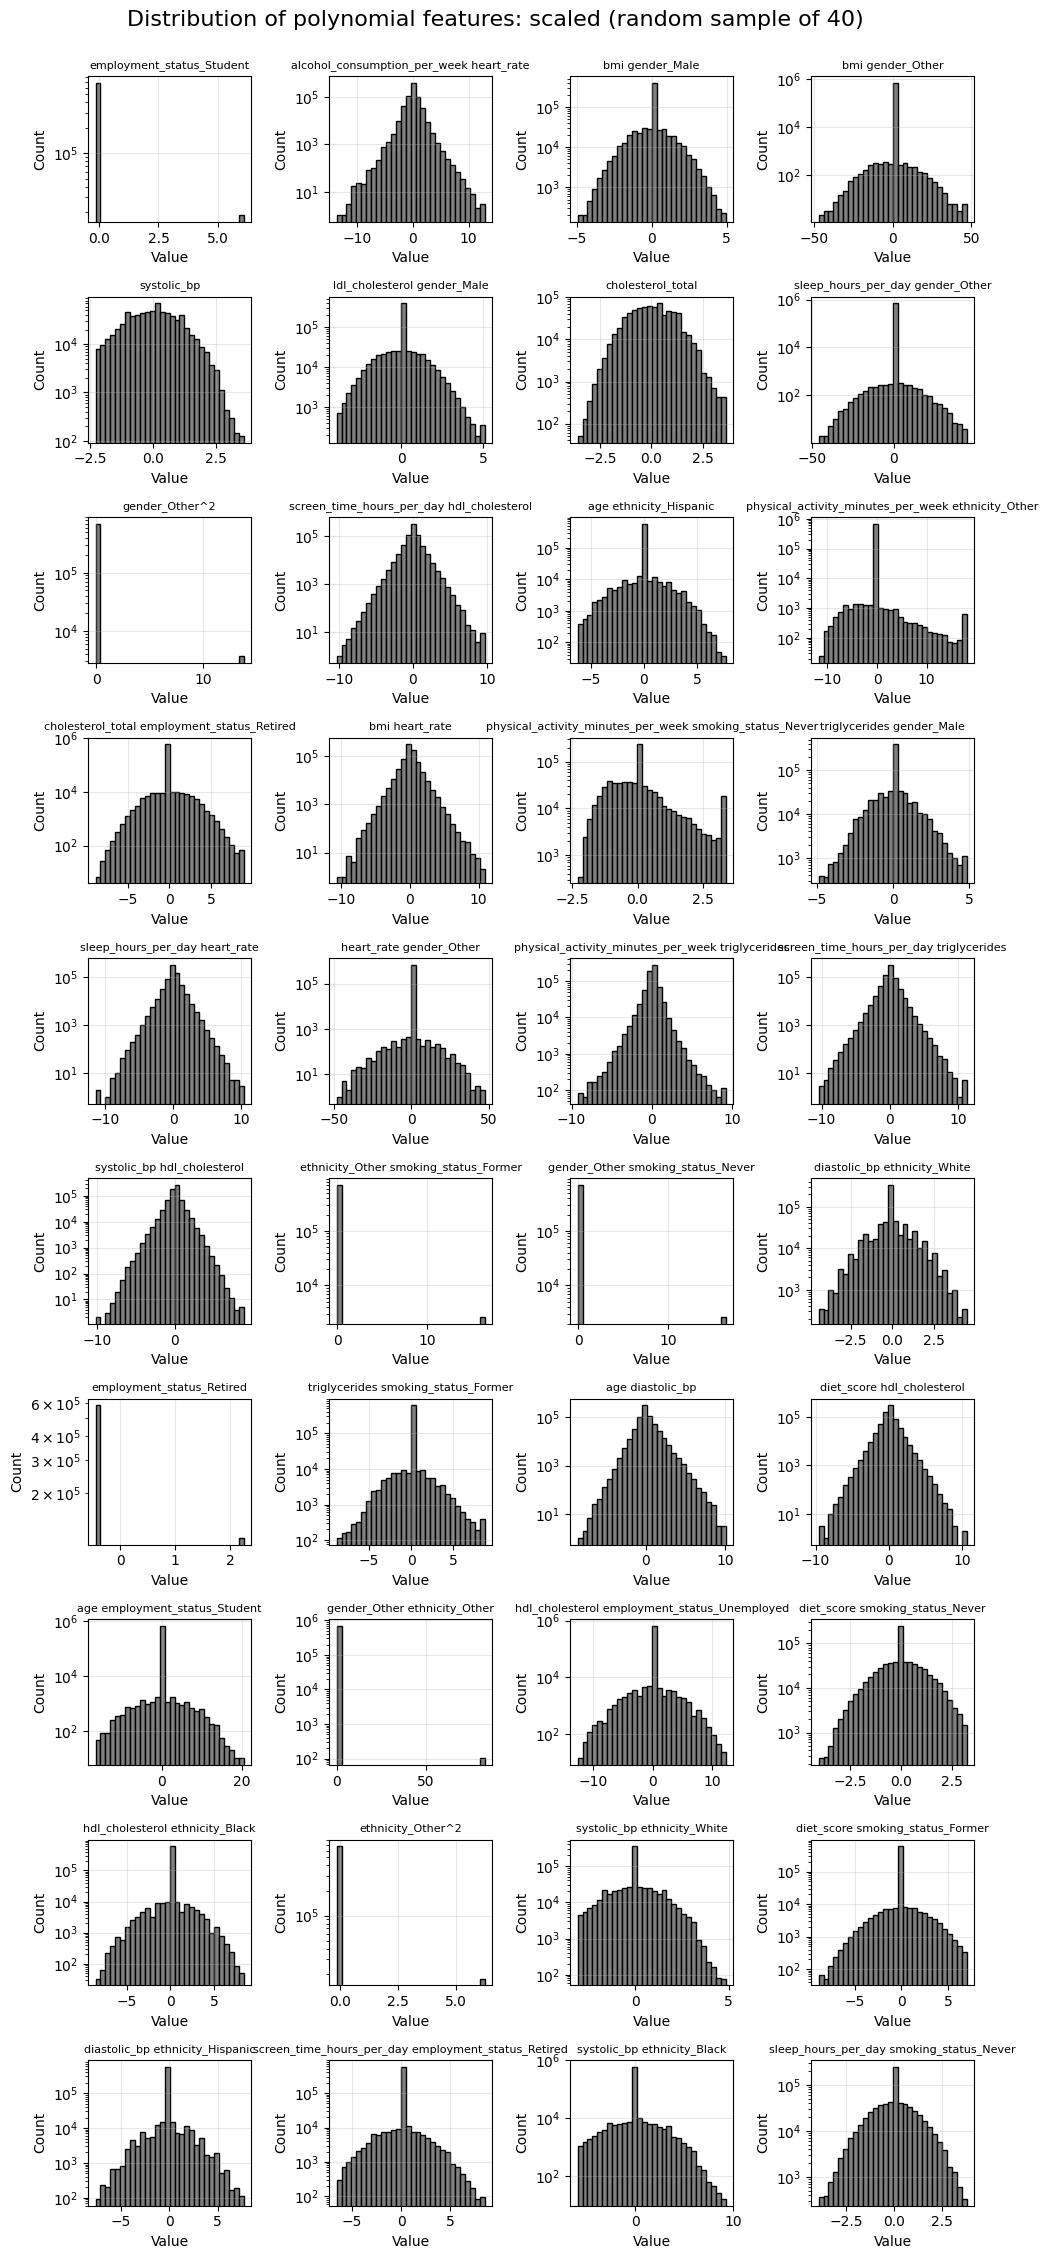

In [16]:
# Create distribution plots for a random sample of clipped and scaled polynomial features
if CHECK_PIPELINE_STEPS:

    sample_size = 40
    sampled_features = np.random.choice(filtered_feature_names, size=min(sample_size, len(filtered_feature_names)), replace=False)

    num_cols = 4
    num_rows = len(sampled_features) // num_cols + (len(sampled_features) % num_cols > 0)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*2.5, num_rows*2.3))
    axes = axes.flatten()
    fig.suptitle(f'Distribution of polynomial features: scaled (random sample of {len(sampled_features)})', fontsize=16)

    for i, feature in enumerate(sampled_features):
        
        # Plot scaled polynomial feature data from training dataframe
        axes[i].hist(train_df[feature], bins=30, edgecolor='black', color='grey')
        axes[i].set_title(f'{feature}', fontsize=8)
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Count')
        axes[i].set_yscale('log')
        axes[i].grid(True, alpha=0.3)

    # Turn off unused axes
    for i in range(len(sampled_features), len(axes)):
        axes[i].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

### 2.5. PCA dimensionality reduction

In [17]:
if CHECK_PIPELINE_STEPS:

    # Create PCA transformer with 40 components (Note: number of components will be optimized later)
    pca = PCA(n_components=40)

    # Apply PCA to the scaled polynomial features
    pca_features = pca.fit_transform(poly_df_final.values)

    # Create DataFrame with PCA features
    pca_feature_names = [f'PC{i+1}' for i in range(pca.n_components)]
    pca_df = pd.DataFrame(pca_features, columns=pca_feature_names, index=train_df.index)

    # Replace features with PCA components
    train_df = pd.concat([train_df[[label]], pca_df], axis=1)

    print(f'PCA components: {pca.n_components}')
    print(f'Explained variance ratio (cumulative): {pca.explained_variance_ratio_.cumsum()[-1]:.4f}')
    print(f'Final training data shape: {train_df.shape}')

PCA components: 40
Explained variance ratio (cumulative): 0.4109
Final training data shape: (700000, 41)


### 2.6. Principal component distributions

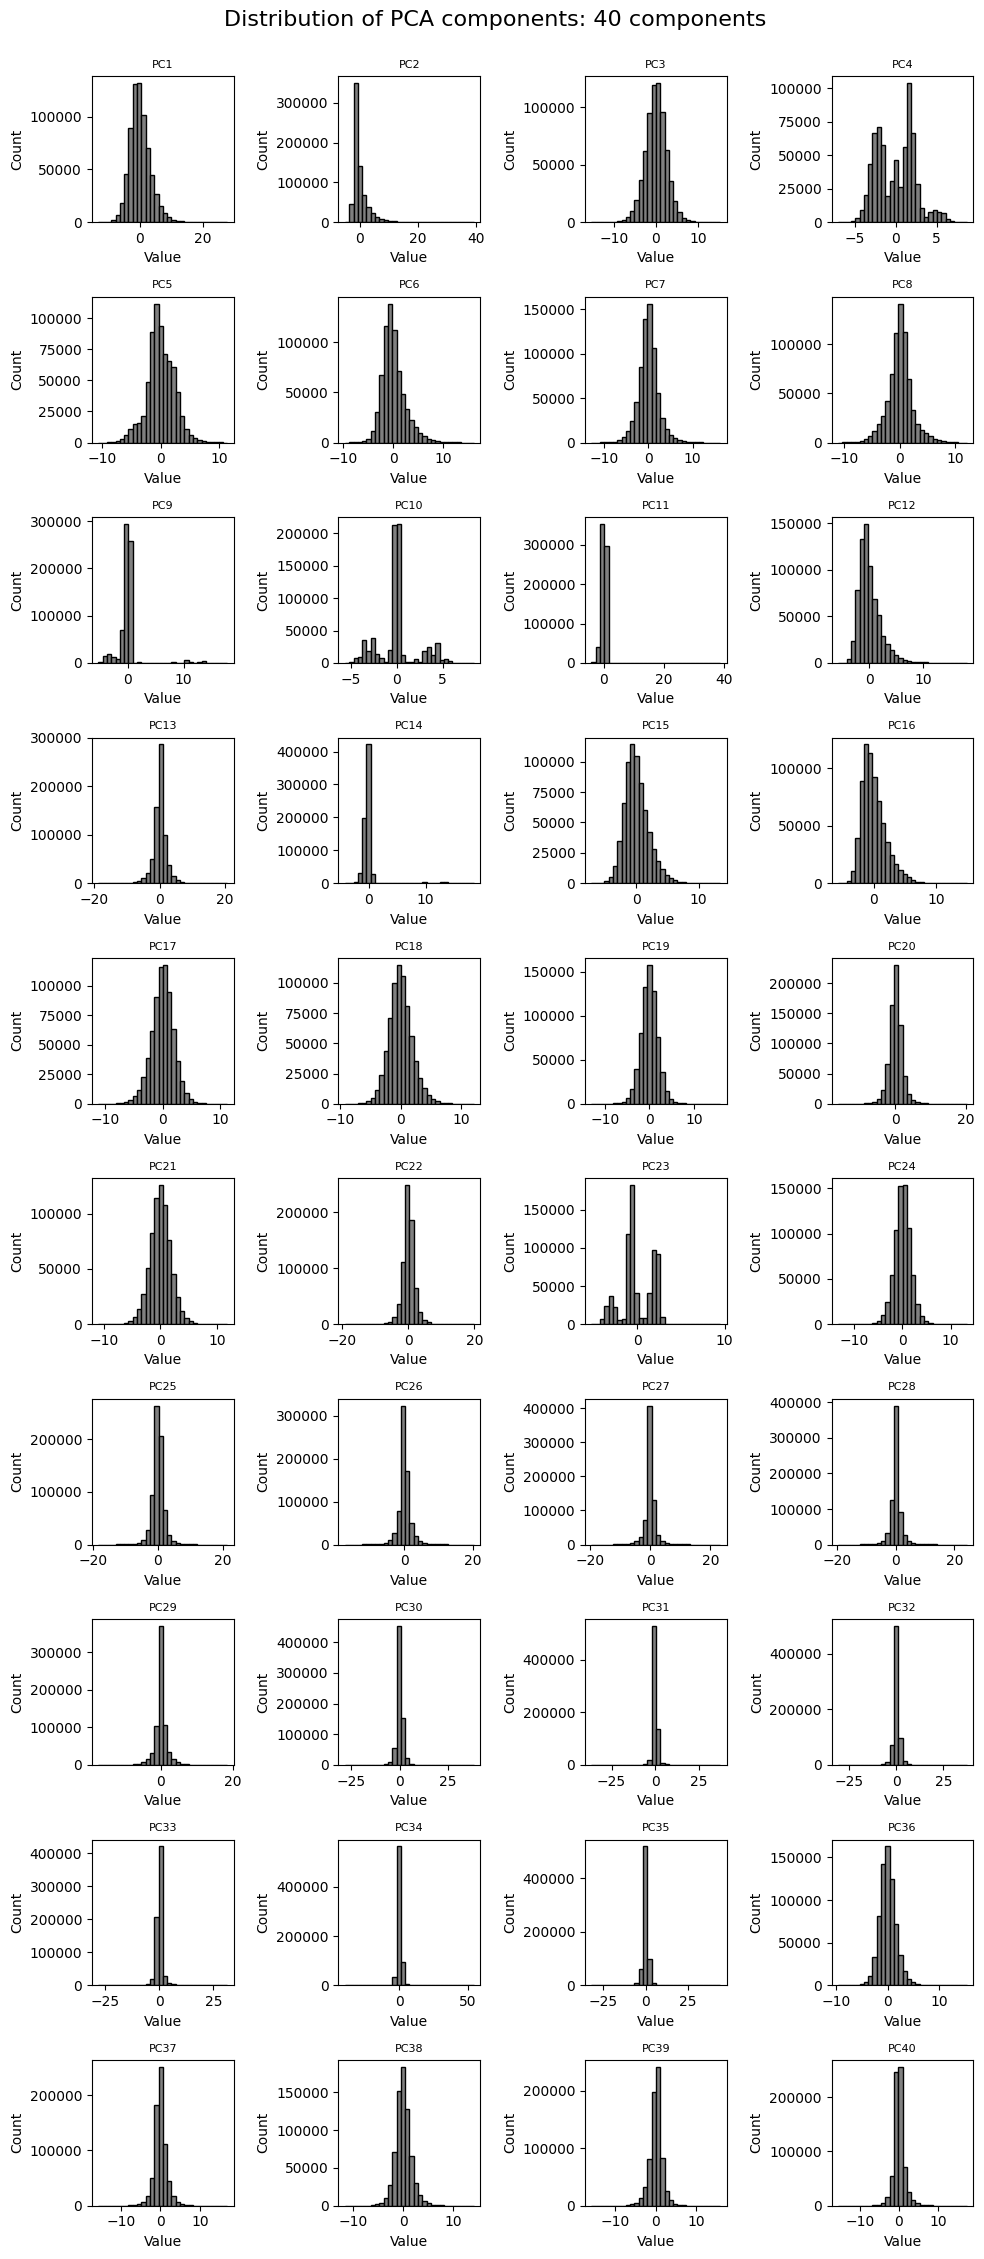

In [18]:
# Create distribution plots for PCA components
if CHECK_PIPELINE_STEPS:

    num_cols = 4
    num_rows = len(pca_feature_names) // num_cols + (len(pca_feature_names) % num_cols > 0)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*2.5, num_rows*2.3))
    axes = axes.flatten()
    fig.suptitle(f'Distribution of PCA components: {pca.n_components} components', fontsize=16)

    for i, feature in enumerate(pca_feature_names):
        
        # Plot PCA component data from training dataframe
        axes[i].hist(train_df[feature], bins=30, edgecolor='black', color='grey')
        axes[i].set_title(f'{feature}', fontsize=8)
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Count')

    # Turn off unused axes
    for i in range(len(pca_feature_names), len(axes)):
        axes[i].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

## 3. Model building

In [19]:
# Reload training dataset for model optimization
train_df = pd.read_csv(train_df_path)

# Drop any duplicate rows
train_df.drop_duplicates(inplace=True)

### 3.1. Model pipeline definition

In [20]:
# Create preprocessing pipeline for numerical features
numerical_pipeline = Pipeline([
    ('clipper', IQRClipper()),
    ('scaler', StandardScaler())
])

# Create fresh encoder instances for the pipeline
ordinal_encoder_pipeline = OrdinalEncoder(
    categories=education_categories + income_categories,
    handle_unknown='use_encoded_value',
    unknown_value=-1
)

onehot_encoder_pipeline = OneHotEncoder(
    drop='first',
    sparse_output=False,
    handle_unknown='ignore'
)

# Create column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('ord', ordinal_encoder_pipeline, ordinal_features),
        ('nom', onehot_encoder_pipeline, nominal_features)
    ]
)

# Create full feature engineering & estimator pipeline
pipeline = Pipeline([
    ('id_dropper', IDColumnDropper(id_column='id')),
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('constant_remover', ConstantFeatureRemover()),
    ('scaler_post_poly', StandardScaler()),
    ('pca', PCA()),
    ('logit', LogisticRegression())
])

pipeline

Pipeline(steps=[('id_dropper', IDColumnDropper()),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('clipper',
                                                                   IQRClipper()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'alcohol_consumption_per_week',
                                                   'physical_activity_minutes_per_week',
                                                   'diet_score',
                                                   'sleep_hours_per_day',
                                                   'screen_time_hours_per_day',
                                                   'bmi', 'waist_to_hip_ratio',
                                                   'systolic_...
                                                  ['education_level',
                                                   'income_level']),
                                                 ('nom',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['gender', 'ethnicity',
                                                   'smoking_status',
                                                   'employment_status'])])),
                ('poly', PolynomialFeatures(include_bias=False)),
                ('constant_remover', ConstantFeatureRemover()),
                ('scaler_post_poly', StandardScaler()), ('pca', PCA()),
                ('logit', LogisticRegression())])

### 3.2. Model pipeline hyperparameter search space

In [ ]:
# Define parameter distributions for optimization
param_distributions = [
    {
        'preprocessor__num__clipper__iqr_multiplier': uniform(loc=1.25, scale=2.25),
        'poly__degree': [2, 3, 4],
        'poly__include_bias': [True, False],
        'poly__interaction_only': [False, True],
        'pca__n_components': randint(50, 401),
        'pca__svd_solver': ['randomized'],
        'pca__whiten': [True, False],
        'logit__C': loguniform(0.001, 100),
        'logit__penalty': ['l2'],
        'logit__max_iter': [1000],
        'logit__class_weight': ['balanced'],
        'logit__n_jobs': [N_JOBS],
    },
    {
        'preprocessor__num__clipper__iqr_multiplier': uniform(loc=1.25, scale=2.25),
        'poly__degree': [2, 3, 4],
        'poly__include_bias': [True, False],
        'poly__interaction_only': [False, True],
        'pca__n_components': randint(50, 401),
        'pca__svd_solver': ['randomized'],
        'pca__whiten': [True, False],
        'logit__penalty': [None],
        'logit__max_iter': [1000],
        'logit__class_weight': ['balanced'],
        'logit__n_jobs': [N_JOBS],
    }
]

### 3.3. RandomizedSearchCV resource requirement testing

In [22]:
# Define experimental parameters
sample_sizes = [1000, 2000, 4000, 8000]
n_iters = [4, 8, 16, 32]

# Define path for saving/loading results
data_dir = Path('../data')
runtime_results_path = data_dir / 'runtime_experiment_results.csv'

if RANDOM_SEARCH_TEST:

    # Runtime and memory experiment
    results_df, full_dataset_size = random_search_test(
        train_df_path=train_df_path,
        label=label,
        pipeline=pipeline,
        param_distributions=param_distributions,
        sample_sizes=sample_sizes,
        n_iters=n_iters,
        random_state=RANDOM_STATE,
        n_jobs=1,
        data_dir=data_dir,
        results_filename='runtime_experiment_results.csv'
    )

else:

    # Load results from disk
    results_df = pd.read_csv(runtime_results_path)
    full_dataset_size = len(pd.read_csv(train_df_path))
    
    # Use sample sizes from the loaded data
    sample_sizes = sorted(results_df['sample_size'].unique().tolist())
    
    print(f'Loaded {len(results_df)} results from: {runtime_results_path}')
    print(f'Sample sizes in data: {sample_sizes}')

# Display results
results_df.head(10)

Loaded 48 results from: ../data/runtime_experiment_results.csv
Sample sizes in data: [1000, 2000, 4000, 8000]


,sample_size,n_iter,replicate,runtime_seconds,peak_memory_mb
0,1000,4,1,27.279874,372.895895
1,1000,4,2,32.279517,534.031651
2,1000,4,3,30.919107,800.039844
3,1000,8,1,31.549726,534.198689
4,1000,8,2,51.778003,537.413422
5,1000,8,3,47.372459,800.040458
6,1000,16,1,73.394531,534.219612
7,1000,16,2,72.658536,537.356283
8,1000,16,3,84.983921,550.253510
9,1000,32,1,141.101698,537.903314


#### 3.3.1. Memory footprint modeling

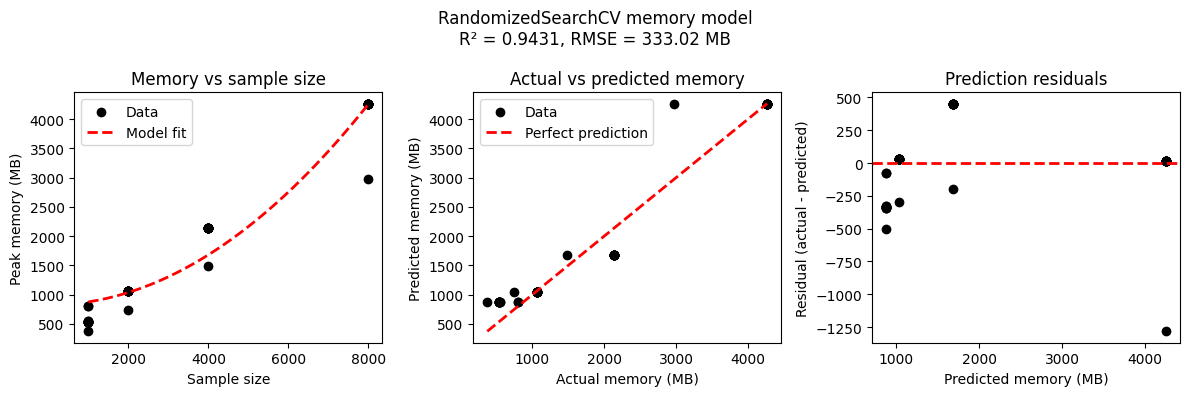

In [23]:
# Build linear regression model to predict memory usage
memory_model, memory_stats, results_with_memory_predictions = build_memory_model(results_df)

# Create and display the memory model plots
plot_memory_model(memory_model, memory_stats, results_df, results_with_memory_predictions)

In [24]:
# Calculate optimal sample size based on MEMORY_LIMIT_GB
optimal_sample_size, memory_details = calculate_optimal_sample_size(
    memory_model,
    MEMORY_LIMIT_GB
)

# Calculate percentage of full dataset
percentage = (optimal_sample_size / full_dataset_size) * 100

print(f'Memory limit: {MEMORY_LIMIT_GB} GB ({int(memory_details["memory_limit_mb"])} MB)')
print(f'Optimal sample size: {optimal_sample_size:,} samples ({percentage:.1f}% of the full dataset)')

Memory limit: 30 GB (30720 MB)
Optimal sample size: 23,621 samples (3.4% of the full dataset)


#### 3.3.2. Runtime modeling

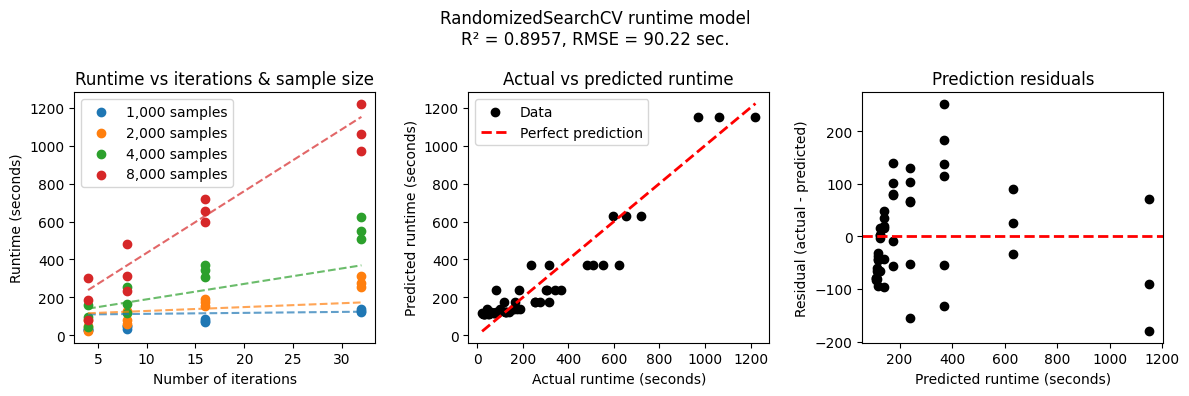

In [25]:
# Build linear regression model to predict runtime
runtime_model, runtime_stats, results_with_runtime_predictions = build_runtime_model(results_df)

# Create and display the runtime model plots
plot_runtime_model(runtime_model, runtime_stats, results_df, results_with_runtime_predictions, sample_sizes)

In [26]:
# Calculate optimal number of iterations for optimal_sample_size based on RUNTIME_LIMIT_MIN
optimal_n_iter, runtime_details = calculate_optimal_iterations(
    runtime_model,
    optimal_sample_size,
    RUNTIME_LIMIT_MIN
)

print(f'Runtime limit: {RUNTIME_LIMIT_MIN} minutes ({int(runtime_details["runtime_limit_seconds"])} seconds)')
print(f'Sample size: {optimal_sample_size:,} samples')
print(f'Optimal iterations: {optimal_n_iter}')
print(f'Predicted runtime: {runtime_details["predicted_runtime_seconds"]:.1f} seconds ({runtime_details["predicted_runtime_minutes"]:.1f} minutes)')

Runtime limit: 1440 minutes (86400 seconds)
Sample size: 23,621 samples
Optimal iterations: 303
Predicted runtime: 86152.8 seconds (1435.9 minutes)


In [27]:
# Draw a random sample of the optimal size
train_sample = train_df.sample(n=optimal_sample_size, random_state=RANDOM_STATE)

print(f'Original dataset size: {len(train_df):,} samples')
print(f'Sampled dataset size: {len(train_sample):,} samples')
print(f'Sample is {(len(train_sample)/len(train_df)*100):.1f}% of original data')

Original dataset size: 700,000 samples
Sampled dataset size: 23,621 samples
Sample is 3.4% of original data


### 3.4. RandomizedSearchCV optimization run

In [28]:
# Create RandomizedSearchCV with optimal number of iterations
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=optimal_n_iter,
    scoring='roc_auc',
    n_jobs=8,
    cv=CV_FOLDS,
    random_state=RANDOM_STATE,
    verbose=1
)

start_optimization = time.time()
random_search.fit(train_sample.drop(columns=[label]), train_sample[label])
optimization_time = time.time() - start_optimization

# Display best parameters and score
print(f'\nActual runtime: {optimization_time:.1f} seconds ({optimization_time/60:.1f} minutes)')
print(f'Best cross-validation ROC-AUC score: {random_search.best_score_:.4f}')
print('\nBest parameters:')

for param, value in random_search.best_params_.items():
    print(f'  {param}: {value}')

Fitting 3 folds for each of 303 candidates, totalling 909 fits


KeyboardInterrupt: 

### 3.5. Final model training

In [ ]:
# Separate features and target from the sample
X_train_sample = train_sample.drop(columns=[label])
y_train_sample = train_sample[label]

# Get the best model from randomized search (already trained on best params)
best_model = random_search.best_estimator_

# Retrain on sampled dataset with best parameters
best_model.fit(X_train_sample, y_train_sample)
print(f'Model retrained on {len(X_train_sample):,} samples')

## 4. Inference resource testing

### 4.1. Load test data

In [ ]:
test_df_path = 'https://gperdrizet.github.io/FSA_devops/assets/data/unit3/diabetes_prediction_test.csv'

# Load the test dataset
test_df = pd.read_csv(test_df_path)

# Display first few rows of test data
print(f'Test dataset shape: {test_df.shape}')
test_df.head().transpose()

### 4.2. Test set inference memory requirements

In [ ]:
# Start memory tracking
tracemalloc.start()

# Time the inference call
start_time = time.perf_counter()

predictions = best_model.predict(test_df)

end_time = time.perf_counter()
inference_time = end_time - start_time

# Get peak memory usage during prediction
current_memory, peak_memory = tracemalloc.get_traced_memory()
tracemalloc.stop()

# Convert to GB
memory_footprint_gb = peak_memory / (1024 * 1024 * 1024)

# Calculate throughput
samples_per_second = len(test_df) / inference_time

print(f'\nInference performance metrics:')
print(f'  Dataset size: {len(test_df):,} samples')
print(f'  Inference time: {inference_time:.4f} seconds')
print(f'  Throughput: {samples_per_second:,.0f} samples/second')
print(f'  Peak memory: {memory_footprint_gb:.4f} GB')

## 5. Save Model

In [ ]:
# Define model directory and ensure it exists
model_dir = Path('../models')
model_dir.mkdir(parents=True, exist_ok=True)

# Create model filename
model_name = 'logistic_regression'
model_path = model_dir / f'{model_name}.joblib'

# Save the pipeline
joblib.dump(best_model, model_path)
print('Model saved to:', model_path)

## 6. Save model description

In [ ]:
# Create model description filename
markdown_path = model_dir / f'{model_name}.md'

# Create markdown description
markdown_content = f"""# Logistic Regression Model for Diabetes Prediction

## Model overview

This is a scikit-learn Pipeline object that chains together multiple preprocessing, feature engineering, and modeling steps into a single estimator. Pipelines ensure that all transformations are applied consistently during both training and inference, preventing data leakage and simplifying deployment. The pipeline was optimized using RandomizedSearchCV with resource constraints and serialized using joblib for efficient storage and loading of the fitted transformers and model.

Key features:
- **End-to-end processing**: Automatically handles all preprocessing from raw data to predictions
- **Reproducible transformations**: All fitted parameters (scalers, encoders, PCA components) are preserved
- **Hyperparameter optimization**: Parameters across all pipeline steps were jointly optimized
- **Resource-aware training**: Model was trained within specified memory ({MEMORY_LIMIT_GB}GB) and runtime ({RUNTIME_LIMIT_MIN} min) constraints

For details on model optimization and training, see the [Jupyter notebook on GitHub](https://github.com/gperdrizet/diabetes-prediction/blob/main/notebooks/01.1-logistic_regression_model.ipynb).

## Files

- **Model file**: `{model_path.name}` (scikit-learn Pipeline object serialized with joblib)
- **Custom transformers**: `logistic_regression_transformers.py` (required for model deserialization)
- **Documentation**: `{markdown_path.name}`

## Training information

- **Training date**: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
- **Training samples**: {len(X_train_sample):,}
- **Random state**: {RANDOM_STATE}
- **Cross-validation score (ROC-AUC)**: {random_search.best_score_:.4f}

## Hyperparameter optimization

- **Method**: Randomized Search CV
- **Cross-validation folds**: {CV_FOLDS}
- **Iterations**: {optimal_n_iter}
- **Scoring metric**: ROC-AUC
- **Optimization runtime**: {optimization_time:.1f} seconds ({optimization_time/60:.1f} minutes)

## Inference performance

Measured on test dataset with {len(test_df):,} samples using `tracemalloc` to track peak memory allocation:

- **Inference time**: {inference_time:.4f} seconds
- **Throughput**: {samples_per_second:,.0f} samples/second
- **Peak memory**: {memory_footprint_gb:.4f} GB

## Pipeline components

### 1. Preprocessing

#### ID column removal
- **ID column dropper**: Automatically removes the 'id' column from input data (custom transformer)

#### Numerical features
- **IQR clipping**: Outlier clipping using interquartile range (multiplier: {random_search.best_params_.get('preprocessor__num__clipper__iqr_multiplier', 'N/A'):.2f}) *[optimized]* (custom transformer)
- **Standardization**: Standard scaling (mean=0, std=1)
- **Features**: age, alcohol_consumption_per_week, diet_score, physical_activity_minutes_per_week, sleep_hours_per_day, screen_time_hours_per_day, bmi, waist_to_hip_ratio, systolic_bp, diastolic_bp, heart_rate, cholesterol_total, hdl_cholesterol, ldl_cholesterol, triglycerides

#### Ordinal features
- **Ordinal encoding**: education_level, income_level

#### Nominal features
- **One-hot encoding**: gender, ethnicity, smoking_status, employment_status, family_history_diabetes, hypertension_history, cardiovascular_history (drop first category)

### 2. Feature engineering

- **Polynomial features**:
  - Degree: {random_search.best_params_.get('poly__degree', 'N/A')} *[optimized]*
  - Include bias: {random_search.best_params_.get('poly__include_bias', 'N/A')} *[optimized]*
  - Interaction only: {random_search.best_params_.get('poly__interaction_only', 'N/A')} *[optimized]*

- **Constant feature removal**: Removes features with zero variance (custom transformer)

- **Post-polynomial standardization**: Standard scaling after polynomial transformation

- **PCA dimensionality reduction**:
  - Components: {random_search.best_params_.get('pca__n_components', 'N/A')} *[optimized]*
  - SVD solver: {random_search.best_params_.get('pca__svd_solver', 'N/A')} *[optimized]*
  - Whiten: {random_search.best_params_.get('pca__whiten', 'N/A')} *[optimized]*

### 3. Classifier

- **Algorithm**: Logistic regression
- **Penalty**: {random_search.best_params_.get('logit__penalty', 'N/A')} *[optimized]*
- **Regularization (C)**: {f"{random_search.best_params_.get('logit__C'):.4f}" if random_search.best_params_.get('logit__C') is not None else 'N/A'} *[optimized]*
- **Max iterations**: {random_search.best_params_.get('logit__max_iter', 'N/A')}
- **Class weight**: {random_search.best_params_.get('logit__class_weight', 'N/A')}

## Custom transformers

The model uses three custom scikit-learn transformers defined in `logistic_regression_transformers.py`:

### IDColumnDropper
Automatically removes the 'id' column from input DataFrames before processing. This allows the model to accept raw test data without manual preprocessing.

### IQRClipper
Clips outliers in numerical features based on the interquartile range (IQR). During fitting, calculates clipping bounds as Q1 - k×IQR and Q3 + k×IQR, where k is the optimized multiplier. This reduces the impact of extreme outliers while preserving the overall distribution.

### ConstantFeatureRemover
Removes features with zero variance after polynomial transformation. This eliminates redundant features that don't contribute to model predictions, reducing dimensionality and improving computational efficiency.

**Important**: The `logistic_regression_transformers.py` file must be available in the Python path when loading the model, as joblib stores references to these classes and needs to import them during deserialization.

## Usage

```python
import joblib
import pandas as pd
import sys
from pathlib import Path

# Add the models directory to the path (adjust as needed)
sys.path.insert(0, str(Path('models').resolve()))

# Load the model (this will import the custom transformers)
model = joblib.load('models/{model_path.name}')

# Prepare test data (pipeline will automatically handle 'id' column)
X_test = pd.read_csv('test.csv')

# Make predictions
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)
```

## Notes

- Input data can include the 'id' column - it will be automatically removed by the pipeline
- The pipeline handles all preprocessing and feature engineering automatically
- All transformations are applied in the correct sequence without requiring manual intervention
- Model was trained with resource constraints: {MEMORY_LIMIT_GB}GB memory limit, {RUNTIME_LIMIT_MIN} minute runtime limit
- The `logistic_regression_transformers.py` file must be in the Python path when loading the model
"""

with open(markdown_path, 'w') as f:
    f.write(markdown_content)

print('Model description saved to:', markdown_path)